##### В A/B тесте было два варианта работы сервиса - standard и svm_ensemble_v_1_22, где работала модель классификации пользователей.
##### Ответьте на 2 вопроса:
 - Стоит ли нам оставить старый вариант работы или заменить на вариант svm_ensemble_v_1_22 (используем всю выборку 200к+ записей)
 - Так же посчитайте вывод для типа пользователей (user_type) стоит ли для новых/старых пользователей (new/registered user) оставить старый / новый вариант работы (разделяем всю выборку 200к+ записей на группы)


In [2]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import statsmodels.stats.api as sms
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil

%matplotlib inline

plt.style.use('seaborn-whitegrid')
font = {'family' : 'Helvetica',
        'weight' : 'bold',
        'size'   : 14}
mpl.rc('font', **font)

In [4]:
users_df = pd.read_csv('ab_test_ensembles.csv')

In [6]:
users_df.head()

,user_id,timestamp,group,variants,converted,location,age_group,user_type
0,9109b0dc-d393-497f-8d63-ba9a25dd16b4,2022-05-21 22:11:48.556739,control,standard,0,United Kingdom,18-25,registered_user
1,2430c3d2-f75b-4b31-8271-51b6a76c2652,2022-05-12 08:01:45.159739,control,standard,0,United Kingdom,42-49,registered_user
2,44788c4e-8dd2-4fad-b986-75e76f4adb64,2022-05-11 16:55:06.154213,treatment,svm_ensemble_v_1_22,0,United Kingdom,26-33,new_user
3,4699a417-506d-41b8-a354-6af6ad576963,2022-05-08 18:28:03.143765,treatment,svm_ensemble_v_1_22,0,United Kingdom,42-49,registered_user
4,304b0d28-bcdf-401a-9dff-66230d3ba0bc,2022-05-21 01:52:26.210827,control,standard,1,United Kingdom,42-49,registered_user


In [17]:
users_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 8 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   user_id    294478 non-null  object
 1   timestamp  294478 non-null  object
 2   group      294478 non-null  object
 3   variants   294478 non-null  object
 4   converted  294478 non-null  int64 
 5   location   294478 non-null  object
 6   age_group  294478 non-null  object
 7   user_type  294478 non-null  object
dtypes: int64(1), object(7)
memory usage: 18.0+ MB


#### 1. Стоит ли нам оставить старый вариант работы или заменить на вариант svm_ensemble_v_1_22 (используем всю выборку 200к+ записей)?
#### Гипотеза H0 : p = p0, H1 : p != p0
#### Используем Two - Tailed Test.
#### confidence level = 0.95, a = 0.05
#### Абсолютная разница конверсии 2%

In [89]:
control_df = users_df[users_df['variants']=='standard']
threat_df = users_df[users_df['variants']=='svm_ensemble_v_1_22']
ratio = control_df.shape[0] / threat_df.shape[0]

effect_size = sms.proportion_effectsize(0.13, 0.15) ### Тут дико не понятно откуда вылезла 2 * (arcsin(sqrt(prop1)) - arcsin(sqrt(prop2))), и как это вяжется с теорией вероятности. 
### То есть у нас биноминальное распределение с p = 0.12, зачем нам arcsin?
### Также не понятно, почему мы используем цифры отвязанные от наших распределений, 0,13 это не среднее, наше реальное среднее на старой версии сайте 0,12.
n = sms.tt_ind_solve_power(effect_size=effect_size, ratio=ratio, power=0.8, alpha=0.05)
print(ceil(n))

-0.0576728617308947
4721


#### То есть нам достаточно сэмпла в 4721, чтобы оценить эффект. Мы же будем использовать всю выборку.

In [90]:
pd.crosstab(users_df['group'], users_df['variants'])

variants,standard,svm_ensemble_v_1_22
group,,
control,145274,1928
treatment,1965,145311


In [91]:
sessions = users_df['user_id'].value_counts(ascending=False)
duplicate_users = sessions[sessions > 1].count()
print(f"У нас имеются {duplicate_users} пользователей, которые не уникальны в нашей выборке.")

У нас имеются 0 пользователей, которые не уникальны в нашей выборке.


In [92]:
conversion_rates = users_df.groupby('group')['converted']

# Стандартное отклонение для сформированной выборки
std_proportion = lambda x: np.std(x, ddof=0)
# Стандартная ошибка для сформированной выборки, формулу стандартной ошибки вы знаете из лекций. Забыли - погуглите.
se_proportion = lambda x: stats.sem(x, ddof=0)

conversion_rates = conversion_rates.agg([np.mean, std_proportion, se_proportion]).rename(columns={'mean':'CR mean', '<lambda_0>':'CR std', '<lambda_1>':'CR se'})
conversion_rates

,CR mean,CR std,CR se
group,,,
control,0.120399,0.325428,0.000848
treatment,0.118920,0.323694,0.000843


Text(0, 0.5, 'Converted (proportion)')

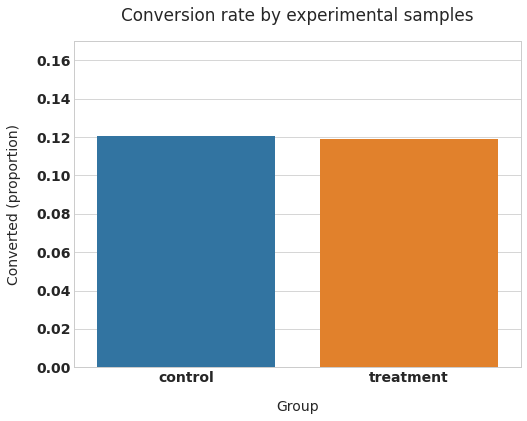

In [93]:
plt.figure(figsize=(8,6))
sns.barplot(x=users_df['group'], y=users_df['converted'], ci=False)
plt.ylim(0, 0.17)
plt.title('Conversion rate by experimental samples', pad=20)
plt.xlabel('Group', labelpad=15)
plt.ylabel('Converted (proportion)', labelpad=15)

In [95]:
from statsmodels.stats.proportion import proportions_ztest, proportion_confint

control_results = users_df[users_df['group'] == 'control']['converted']
treatment_results = users_df[users_df['group'] == 'treatment']['converted']

n_con = control_results.count()
n_treat = treatment_results.count()

successes = [control_results.sum(), treatment_results.sum()]
nobs = [n_con, n_treat]

z_stat, pval = proportions_ztest(successes, nobs=nobs)
(lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(successes, nobs=nobs, alpha=0.05)

print(f'Z-statistic: {z_stat:.2f}')
print(f'p-value: {pval:.3f}')
print(f'CI 95% for control group: [{lower_con:.3f}, {upper_con:.3f}]')
print(f'CI 95% for treatment group: [{lower_treat:.3f}, {upper_treat:.3f}]')

Z-statistic: 1.24
p-value: 0.216
CI 95% for control group: [0.119, 0.122]
CI 95% for treatment group: [0.117, 0.121]


#### Так как наше p-значение = 0.216 что является высоким показателем по сравнению с выбранной альфой 0.05, то согласно статистическому выводу, мы не можем отклонить нулевую гипотезу H0, что означает наш сайт никак статистически значимо не влияет на уровень конверсии.

#### Доверительный интервал для испытуемой группы [0.11, 0.12] или 11% и 12% соответственно:
 - Он не включает наш baseline
 - Он не достигает нашей цели 15%

#### Мы можем интерпритировать это как - наиболее вероятно, что реальный уровень конверсии сайта с новым дизайном будет близок к baseline чем к 15%, который мы определили по нашей цели. Таким образом наиболее рационально будет оставлять текущую версию сайта.
